In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.segmentation import slic, chan_vese
from skimage.color import rgba2rgb, label2rgb, rgb2gray
import numpy as np
from PIL import Image
import time
from arch_grid import Grid
import cv2 as cv
from scipy import interpolate
from tqdm import tqdm
from sklearn.cluster import KMeans

#### Setup: Loading image & line segments function

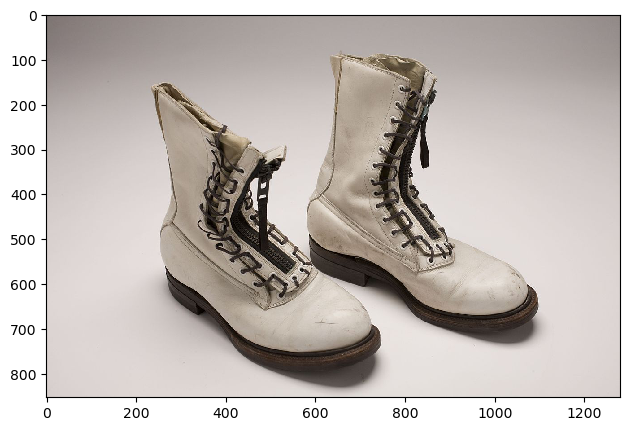

In [2]:
file = '../../images_test/boots.jpg'
source = io.imread(file)
io.imshow(source)

In [6]:
# Helper function, returns either endpoint coordinates, or midpoint coordinates + angle
# Copy of the code, because we want to get the line segments

def getLines(filename, N=500, npoints=40000, radius=0.003, length=0.005, pointsize=0.4, linewidth=0.3):
    image = Image.open(filename).convert("L")

    if image.width != image.height:
        print("Resize the image to size %ix%i" %(N,N))
        image = image.resize((N, N))
    image = np.array(image, dtype=float)[-1::-1,:]
    density_map = np.max(image) - image

    # Apply minimum threshold to avoid zero density areas
    density_map = np.clip(density_map, 10, None)

    start = time.time()

    # Initialize vectors of points coordinates (x,y)
    x_coord_point = []
    y_coord_point = []

    # Constant
    max_nb_cfails = 5000
    max_nb_points = npoints

    grid = Grid(N, density_map, radius)

    num_failure = 0
    points_found  = 0
    while points_found < max_nb_points and num_failure < max_nb_cfails:
        is_not_valid, p = grid.new_point()
        
        # If the point is non-valid, count a failure and skip
        if is_not_valid:
            num_failure += 1
            
        # Else, the point is valid and is stored. We reset the num_failure
        else:
            num_failure = 0
            points_found += 1
            x_coord_point.append(p.x)
            y_coord_point.append(p.y)
            
            percent = int(max_nb_points / 10)
            if points_found % percent == 0:
                intermediate_time = time.time() - start
                formated_time = time.strftime("%H:%M:%S", time.gmtime(intermediate_time))
                progress = 100*points_found/max_nb_points
                print("Time: %s | Percentage: %2.2f %%" %(formated_time, progress))

    print(f"Finally we use {points_found} points.")


    depth = cv.CV_16S
    grad_x = cv.Sobel(src=image, ddepth=depth, dx=1, dy=0, ksize=5)
    grad_y = cv.Sobel(src=image, ddepth=depth, dx=0, dy=1, ksize=5)

    # interpolate the gradient
    grad_x = cv.resize(grad_x, (N, N)).clip(0.1, 100)
    grad_y = cv.resize(grad_y, (N, N)).clip(0.1, 100)
    # maximum gradient value
    grad_ = np.sqrt(grad_x**2 + grad_y**2)
    grad_normalize_x = grad_x/grad_
    grad_normalize_y = grad_y/grad_
    
    x = np.arange(0, N, 1)
    y = np.arange(0, N, 1)
    grad_x_interpolate = interpolate.interp2d(x, y, grad_normalize_x, kind='linear')
    grad_y_interpolate = interpolate.interp2d(x, y, grad_normalize_y, kind='linear')

    endpoints = np.zeros((len(x_coord_point), 4))
    midpoints = np.zeros((len(x_coord_point), 2))
    angles = np.zeros((len(x_coord_point), 1))

    for i in tqdm(range(len(x_coord_point))):
        x_0 = x_coord_point[i]
        y_0 = y_coord_point[i]
        grad_x_0 = grad_x_interpolate(x_0*N, y_0*N)[0]
        grad_y_0 = grad_y_interpolate(x_0*N, y_0*N)[0]

        x_1 = x_0 - length*grad_y_0
        y_1 = y_0 + length*grad_x_0
        x_2 = x_0 + length*grad_y_0
        y_2 = y_0 - length*grad_x_0
        # ipdb.set_trace()

        angle = np.arctan2(grad_y_0, grad_x_0)

        endpoints[i] = x_1, y_1, x_2, y_2
        midpoints[i] = x_0, y_0
        angles[i] = angle
    
    return endpoints, midpoints, angles

# Segmentation as a post-process

We segment the input image first, then apply the results onto the line segments.
In this part, we explore different segmentation algorithms.

## Exploring segmentation algorithms

#### SLIC

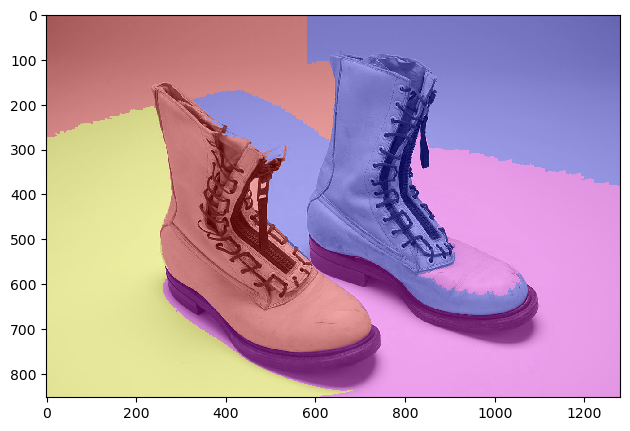

In [4]:
labels = slic(source, n_segments=6, compactness=10)
segmentation = label2rgb(labels, source)
io.imshow(segmentation)

Pretty bad

#### Chan Vese

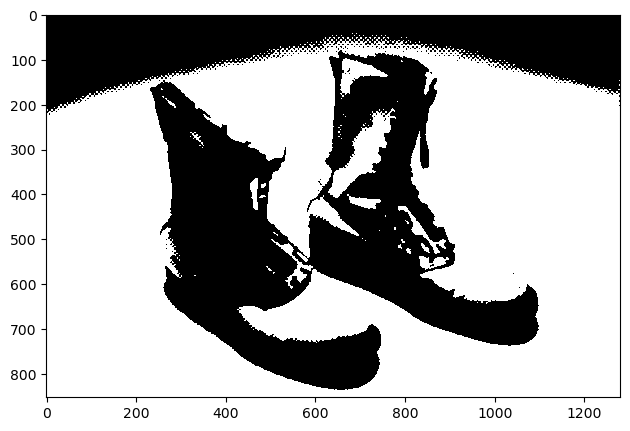

In [4]:
gray = rgb2gray(source)
segmentation = chan_vese(gray)
io.imshow(segmentation)

Okay-ish apart from the top region

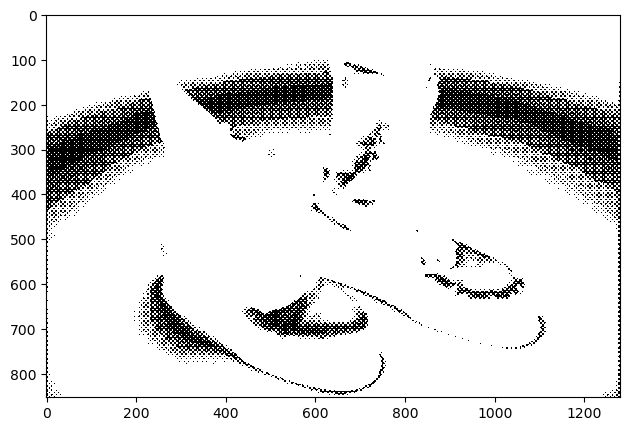

In [5]:
segmentation = chan_vese(gray, max_num_iter=100, tol=0.001, lambda1=0.5)
io.imshow(segmentation)

#### Watershed

In [2]:
def watershed_segmentation(filename):
    """
    https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
    """
    img = cv.imread(filename)
    assert img is not None, "file could not be read, check with os.path.exists()"
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)  

    plt.imshow(thresh)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
    
    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv.watershed(img,markers)
    img[markers == -1] = [255,0,0]

    return markers, img

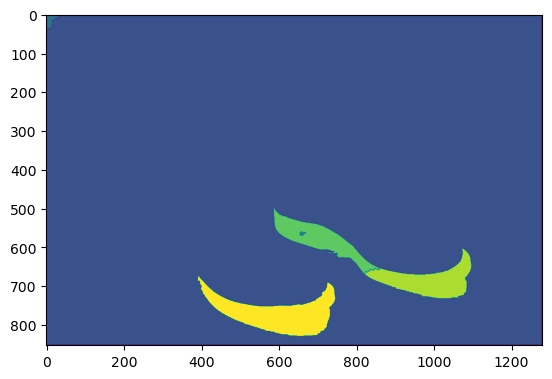

In [5]:
segmented_boots, _ = watershed_segmentation(file)
plt.imshow(segmented_boots)

## Postprocessing

In [19]:
endpoints, _, _ = getLines(file)

Resize the image to size 500x500
Time: 00:00:00 | Percentage: 10.00 %
Time: 00:00:01 | Percentage: 20.00 %
Time: 00:00:03 | Percentage: 30.00 %
Time: 00:00:08 | Percentage: 40.00 %
Time: 00:00:18 | Percentage: 50.00 %
Time: 00:00:53 | Percentage: 60.00 %


C:\Users\schmi\AppData\Local\Temp\ipykernel_38304\1710122574.py:68: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  grad_x_interpolate = interpolate.interp2d(x, y, grad_normalize_x, kind='linear')
C:\Users\schmi\AppData\Local\Temp\ipykernel_38304\1710122574.py:69: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for


Finally we use 25842 points.


  0%|          | 0/25842 [00:00<?, ?it/s]C:\Users\schmi\AppData\Local\Temp\ipykernel_38304\1710122574.py:78: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  grad_x_0 = grad_x_interpolate(x_0*N, y_0*N)[0]
C:\Users\schmi\AppData\Local\Temp\ipykernel_38304\1710122574.py:79: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearl

In [20]:
N=500
image = Image.open(file).convert("L")
image = image.resize((N, N))
image = np.array(image, dtype=float)[-1::-1,:]

segmentation = chan_vese(image, max_num_iter=200)

Text(0.5, 1.0, 'Stippling of 40000 points')

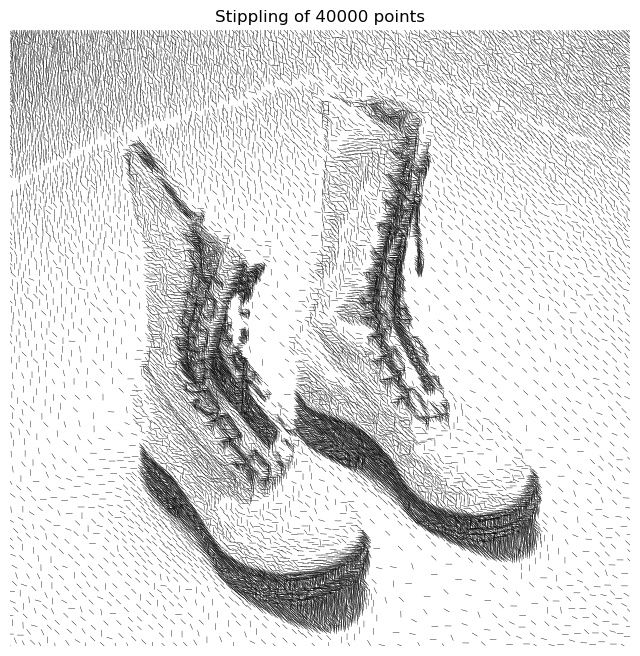

In [22]:
coords = (endpoints * (N-1)).round().astype(int)

plt.figure(figsize=(8,8))
for i in range(len(endpoints)):
    same_segment = True
    if np.all(coords[i] >= 0) and np.all(coords[i] < N): # Avoid cases where line endpoints go out of bounds (could clip instead)
        y_1_s, x_1_s, y_2_s, x_2_s = coords[i] # Due to different frames between segmented image and line segments
        same_segment = segmentation[x_1_s, y_1_s] == segmentation[x_2_s, y_2_s]
    if same_segment:
        x_1, y_1, x_2, y_2 = endpoints[i]
        plt.plot([x_1, x_2], [y_1, y_2], 'k-', linewidth=0.3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.axis("off")
plt.title("Stippling of 40000 points")

# Segmentation on the lines

In [ ]:
_, midpoints, angles = getLines(file)

In [ ]:
weight = 0.5
scaled = np.concatenate((midpoints, angles*weight), axis=1)

In [ ]:
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(scaled)

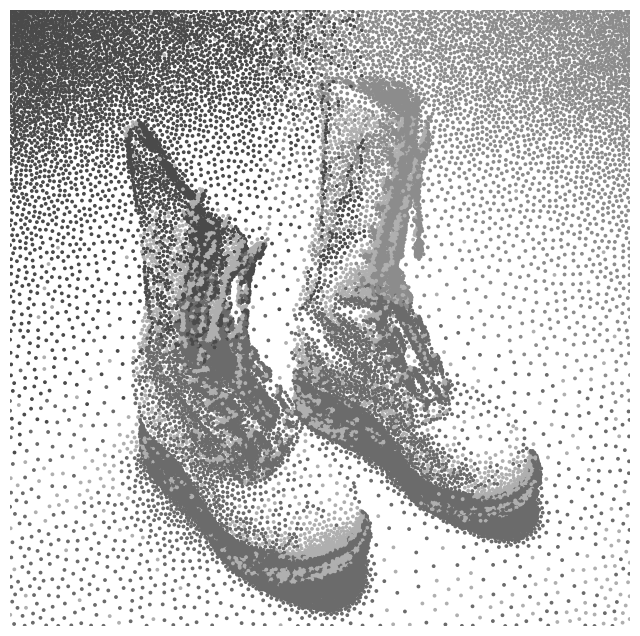

In [109]:
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('Greys')
plt.scatter(lines[:, 0], lines[:, 1], c=cmap(30*labels+107), s=3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.axis("off")
#plt.savefig('kmeans.png', dpi=300)
plt.show()